# Cointegration Arbitrage: Minimum Profit Optimization trading strategy

In this coding project I look to apply to econometrics concept of a cointegrated time-series to pairs trading. The idea is to be able to construct a Z-Score with invariant mean and variance (i.e a time-series integrated of order 0). To determine buying and selling thresholds, we use a "minimum profit optimization" approach. 

To get further explanations about the strategy please refer to the pdf document in the repository.

## Module Import

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import ipynb
import matplotlib.pyplot as plt
from ipynb.fs.full.Functions import * #Refer to this module to see my support functions.
import yfinance as yf

#Here the necessary models to determine our regression coefficients.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#Augmented Dickey-Fuller test to check the cointegration of the Z-Score.
from statsmodels.tsa.stattools import adfuller

## Fetching stock data

In this case, I'll be testing this strategy on 2 regional US banks with less than $10B in total Assets. The idea is that regional banks of this size have a similar product offering and similar customer base, and their performance might be correlated over the long-run.

The selected stocks are TriCo Bancshares and Great Southern Bancorp. I'll train the model with hourly close price data from May-December 2023, and we'll backtest the model with data from January-June 2024.

In [2]:
Stock_A = 'TCBK'
Stock_B = 'GSBC'
start_date = '2023-05-01'
end_date = '2024-01-01'

Stock_A = yf.Ticker(Stock_A)
Stock_B = yf.Ticker(Stock_B)

Prices_A =  Stock_A.history(start=start_date, end=end_date, interval='1h')['Close']
Prices_B =  Stock_B.history(start=start_date, end=end_date, interval='1h')['Close']

data = pd.DataFrame({'Stock_A':Prices_A,'Stock_B':Prices_B})
data = data.dropna()
data

,Stock_A,Stock_B
Datetime,,
2023-05-01 09:30:00-04:00,35.900002,50.965000
2023-05-01 10:30:00-04:00,35.185001,50.660000
2023-05-01 11:30:00-04:00,35.330002,51.000000
2023-05-01 12:30:00-04:00,34.794998,50.720001
2023-05-01 13:30:00-04:00,34.735001,50.639999
...,...,...
2023-12-29 09:30:00-05:00,43.889999,60.599998
2023-12-29 12:30:00-05:00,43.049999,60.000000
2023-12-29 13:30:00-05:00,43.160000,60.020000


## Linear Regression

Price data is considered a integrated of order 1 time series. The properties of cointegration say that for X and Y, two integrated series of order 1, we can make a linear combination "Z" of both X and Y for which Z is integrated of order 0.

We can estimate the coefficient of this linear combination to be the \beta coefficient of the linear regression of A on B.

In [3]:
# Split data into features (X) and target (y)
X = data[['Stock_A']]
y = data['Stock_B']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=None, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Print model coefficients
print("Coefficient:", model.coef_)
print("Intercept:", model.intercept_)

#Store the results
b = model.coef_
a = model.intercept_

Coefficient: [0.91816706]
Intercept: 19.7211431481159


## Building the Z-Score

We use the results from the linear regression to build a Z-Score centered at 0.

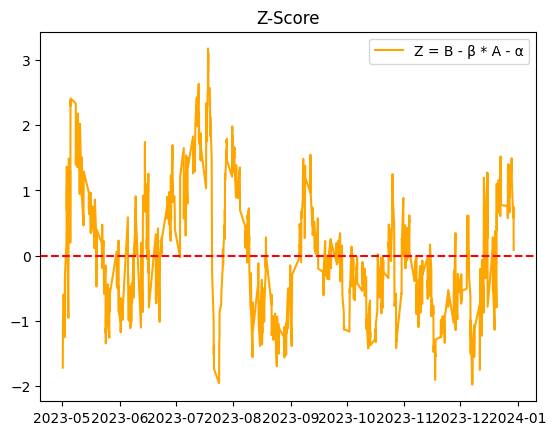

In [4]:
Z = data['Stock_B'] - b * data['Stock_A'] - a

# Plot Z
plt.plot(Z, label='Z', color='orange')

# Plot the mean of Z
plt.axhline(0, color='red', linestyle='--')

# Add title
plt.title('Z-Score')

# Add legend
plt.legend(['Z = B - \u03B2 * A - \u03B1'])

# Show the plot
plt.show()

## Testing for Cointegration

We use the Augmented Dickey-Fuller Test to evaluate whether our Z-Score exhibits stationarity. This test helps determine if there is a unit root in the time series data.

In [5]:
adf = adfuller(Z)[1]

#Print the results
print("p-value is:", adfuller(Z)[1])
if adf>0.05:
    print('Non-Stationary process')
elif adf<0.05:
    print('Stationary process')

p-value is: 0.0005372664441636305
Stationary process


## Determining the buying/selling Threshold with Minimum profit optimization.

We use a maximization program to determine where to pinpoint the trade location. Closer boundaries mean more trades and less profit for trade, whereas farther boundaries reduce the number of trades but increases the minimum profit per trade. This trade-off can be maximized by testing different levels of boundaries with the training data. You can find the implementation of this method in my Functions.ipynb file.


In [6]:
U = Minimum_Optimized_Profit(Z)
print("Trading threshold is: ", U)

/home/juanfrancisco/Juan-Programacion/Proyectos/StatArb/Functions.ipynb:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "    above_U_intervals = []\n",


Trading threshold is:  0.93


## Backtesting the strategy

We'll first start by downloading data from January-June 2024, and we'll plot the Z-Score and boundaries to see where the trades would occur.

/tmp/ipykernel_57525/973236373.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if Z[i] < lower_threshold:
/tmp/ipykernel_57525/973236373.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif Z[i] > upper_threshold:
/tmp/ipykernel_57525/973236373.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if Z[i] < 0:
/tmp/ipykernel_57525/973236373.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. I

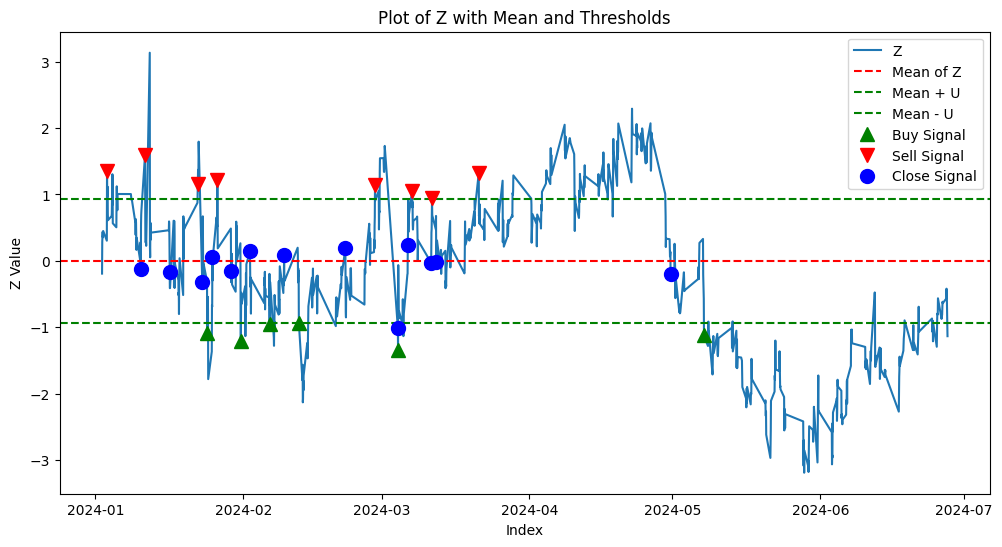

In [7]:
start_date = '2024-01-02'
end_date = '2024-06-28'

Prices_A =  Stock_A.history(start=start_date, end=end_date, interval='1h')['Close']
Prices_B =  Stock_B.history(start=start_date, end=end_date, interval='1h')['Close']

data = pd.DataFrame({'Stock_A':Prices_A,'Stock_B':Prices_B})
data = data.dropna()


Z = data['Stock_B'] - b*data['Stock_A'] - a

# Define the upper and lower thresholds
upper_threshold = U
lower_threshold = -U

# Initialize positions and signals
position = 0
buy_signals = []
sell_signals = []
close_signals = []

# Iterate through Z to generate signals
for i in range(1, len(Z)):
    if position == 0:
        # Generate buy signal
        if Z[i] < lower_threshold:
            buy_signals.append(i)
            position = 1
        # Generate sell signal
        elif Z[i] > upper_threshold:
            sell_signals.append(i)
            position = -1
    elif position == 1:
        # Close buy position
        if Z[i] > 0:
            close_signals.append(i)
            position = 0
    elif position == -1:
        # Close sell position
        if Z[i] < 0:
            close_signals.append(i)
            position = 0

# Plot Z
plt.figure(figsize=(12, 6))
plt.plot(Z, label='Z')

# Plot the mean of Z
plt.axhline(0, color='red', linestyle='--', label='Mean of Z')

# Plot the upper and lower thresholds
plt.axhline(upper_threshold, color='green', linestyle='--', label='Mean + U')
plt.axhline(lower_threshold, color='green', linestyle='--', label='Mean - U')

# Plot buy signals
plt.plot(Z[buy_signals], 'g^', markersize=10, label='Buy Signal')

# Plot sell signals
plt.plot(Z[sell_signals], 'rv', markersize=10, label='Sell Signal')

# Plot close signals
plt.plot(Z[close_signals], 'bo', markersize=10, label='Close Signal')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Z Value')
plt.title('Plot of Z with Mean and Thresholds')
plt.legend()

# Show the plot
plt.show()

### Portfolio Value overtime.

It's important to clarify that the way we trade the strategy is by creating a "self-financing" portfolio. 
The proceeds from the sale of the short leg funds the buying of the long leg.

For this we need to have 150% of the short value as cash in the portfolio as our margin, hence for a portfolio of $1000 we can only short $750.

Profits are reinvested.

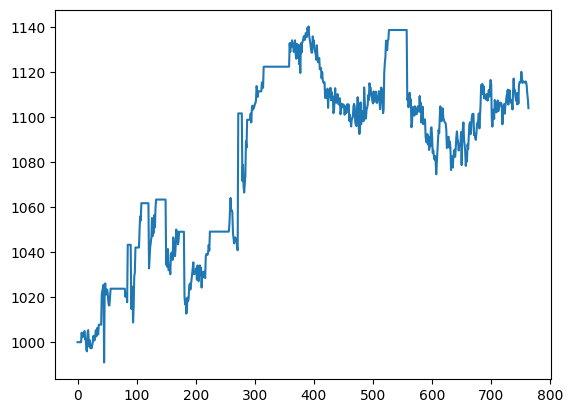

In [8]:
portfolio_value = Backtest(data, Z, U, b,1000,1.5)['Portfolio_Val'] #You can check this backtest function in Functions.ipynb

# Show the plot
plt.plot(portfolio_value)
plt.show()


### Portfolio Statistics

In [10]:
# Assuming portfolio_statistics returns an array or list [ann_return, ann_vol, sharpe_ratio]
result = portfolio_statistics(portfolio_value, 0.0419)

# Printing nicely formatted results
print(f"Annualized Return: {result[0]*100:.2f}%")
print(f"Annualized Volatility: {result[1]*100:.2f}%")
print(f"Sharpe Ratio: {result[2]:.2f}")


Annualized Return: 32.79%
Annualized Volatility: 20.03%
Sharpe Ratio: 1.43
